# **(Data Collection)**

## Objectives

* Prepare and preprocess CT scan images for tumor detection modeling.
* Merge tumor classes into a single "tumor" category.
* Resize all images to 224x224 pixels and normalize pixel values.
* Analyze and address class imbalance using oversampling and augmentation.
* Save processed data and metadata for downstream modeling and visualization.

## Inputs

* Raw CT scan images (tumor and no-tumor) in their respective folders.
* Any available metadata (e.g., image labels, file paths).

## Outputs

* Preprocessed images (224x224, normalized) saved to a structured directory.
* A CSV or DataFrame containing image paths and labels.
* Augmented images for minority class to address imbalance.
* Summary statistics and visualizations of class distribution.

## Additional Comments

* All data must be anonymized and checked for quality before processing.
* Oversampling and augmentation will be applied only to the minority class (no-tumor).
* The notebook should be run top-down, with each step building on the previous.
* Outputs will be used in subsequent modeling and visualization notebooks.

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/brain-tumor-classification/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [ ]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/brain-tumor-classification'

# Data preparation

install important libraries and download data from kaggle

In [9]:
!pip install kagglehub
!pip install opencv-python
!pip install pandas numpy
!pip install scikit-learn
!pip install matplotlib seaborn
!pip install tensorflow
!pip install keras
!pip install imbalanced-learn
!pip install tqdm

import kagglehub
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
print("Path to dataset files:", path)

import shutil
import os

src = "/home/cistudent/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"
dst = "/workspaces/brain-tumor-classification/data"

if not os.path.exists(dst):
    os.makedirs(dst)

for folder in os.listdir(src):
    shutil.copytree(os.path.join(src, folder), os.path.join(dst, folder), dirs_exist_ok=True)


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip insta

**Data Organization**

Data is downloaded and stored in the **data** folder in the root
different tumour types are in seperate folders in the data folder
no_tumour folder data also exists in the data folder in the root

**Image Quality Check:**

Review images for quality, removing corrupted, low-resolution, or irrelevant scans.

In [16]:
# using (Pillow)
from PIL import Image
import os

image_dir = "./data"
min_width, min_height = 100, 100

corrupted_images = []
low_res_images = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    if h < min_height or w < min_width:
                        low_res_images.append(img_path)
            except Exception as e:
                corrupted_images.append(img_path)

print("Corrupted images:", corrupted_images)
print("Low-resolution images:", low_res_images)

# remove these files
for img_path in corrupted_images + low_res_images:
    try:
        os.remove(img_path)
    except Exception as e:
        print(f"Could not remove {img_path}: {e}")

Corrupted images: []
Low-resolution images: []


**Label Verification: Ensure that each image is correctly labeled (tumor or no-tumor).**



Confirms each image is in the correct folder.
Creates a table of image paths and their labels.
spot any mislabeling or misplaced files.
inspect the DataFrame or CSV for errors.

In [20]:
import os
import pandas as pd

image_dir = "./data"
data = []

for label in os.listdir(image_dir):
    label_path = os.path.join(image_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(label_path, file)
                data.append({"image_path": img_path, "label": label})

df = pd.DataFrame(data)
print(df.head())
print("Label counts:\n", df['label'].value_counts())

# Optionally, save to CSV for further use
df.to_csv("image_labels.csv", index=False)

                        image_path      label
0  ./data/pituitary/Tr-pi_0837.jpg  pituitary
1  ./data/pituitary/Te-pi_0263.jpg  pituitary
2  ./data/pituitary/Tr-pi_1277.jpg  pituitary
3  ./data/pituitary/Te-pi_0156.jpg  pituitary
4  ./data/pituitary/Tr-pi_1414.jpg  pituitary
Label counts:
 label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64


**Image Preprocessing:**

Resizing: Standardize to a consistent size (e.g., 224x224 pixels) to match model input requirements.

Normalization: Scale pixel values (e.g., to a 0-1 range) to improve model training stability.

Format Conversion: Convert images to a consistent format (e.g., PNG or JPEG) if necessary. 

Class Merging: If there are multiple tumor types, combine them into a single "tumor" class if the modeling goal is binary classification.

In [22]:
from PIL import Image
import os

input_dir = "./data"
resized_dir = "./resized_data"
target_size = (224, 224)

if not os.path.exists(resized_dir):
    os.makedirs(resized_dir)

for root, dirs, files in os.walk(input_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)
            rel_dir = os.path.relpath(root, input_dir)
            out_dir = os.path.join(resized_dir, rel_dir)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            out_path = os.path.join(out_dir, file)
            try:
                with Image.open(img_path) as img:
                    img = img.resize(target_size)
                    img.save(out_path)
            except Exception as e:
                print(f"Error resizing {img_path}: {e}")
print("Resizing complete. Images saved to:", resized_dir)

Error resizing ./data/notumor/Tr-no_1012.jpg: cannot write mode P as JPEG
Error resizing ./data/notumor/Tr-no_1019.jpg: cannot write mode RGBA as JPEG
Error resizing ./data/notumor/Tr-no_1020.jpg: cannot write mode RGBA as JPEG
Error resizing ./data/notumor/Tr-no_1011.jpg: cannot write mode RGBA as JPEG
Resizing complete. Images saved to: ./resized_data


In [24]:
import numpy as np

normalized_dir = "./normalized_data"

if not os.path.exists(normalized_dir):
    os.makedirs(normalized_dir)

for root, dirs, files in os.walk(resized_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            img_path = os.path.join(root, file)
            rel_dir = os.path.relpath(root, resized_dir)
            out_dir = os.path.join(normalized_dir, rel_dir)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
            out_path = os.path.join(out_dir, os.path.splitext(file)[0] + ".png")  # Convert to PNG
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    arr = np.array(img) / 255.0  # Normalize to 0-1
                    img_norm = Image.fromarray((arr * 255).astype(np.uint8))
                    img_norm.save(out_path, "PNG")
            except Exception as e:
                print(f"Error normalizing {img_path}: {e}")
print("Normalization and format conversion complete. Images saved to:", normalized_dir)

Normalization and format conversion complete. Images saved to: ./normalized_data


In [26]:
merged_dir = "./merged_data"
tumor_folders = ["glioma", "meningioma", "pituitary"]
notumor_folder = "notumor"

if not os.path.exists(merged_dir):
    os.makedirs(merged_dir)

for label in os.listdir(normalized_dir):
    label_path = os.path.join(normalized_dir, label)
    if not os.path.isdir(label_path):
        continue

    # Merge tumor classes
    if label.lower() in tumor_folders:
        out_label = "tumor"
    elif label.lower() == notumor_folder:
        out_label = "notumor"
    else:
        continue

    out_label_dir = os.path.join(merged_dir, out_label)
    if not os.path.exists(out_label_dir):
        os.makedirs(out_label_dir)

    for file in os.listdir(label_path):
        src_file = os.path.join(label_path, file)
        dst_file = os.path.join(out_label_dir, file)
        try:
            os.rename(src_file, dst_file)
        except Exception as e:
            print(f"Error moving {src_file}: {e}")
print("Class merging complete. Images saved to:", merged_dir)

Class merging complete. Images saved to: ./merged_data


check for class imbalance in updated  dataset

also define df again as it's been changed after processing

Label counts:
 label
tumor      5023
notumor    1996
Name: count, dtype: int64


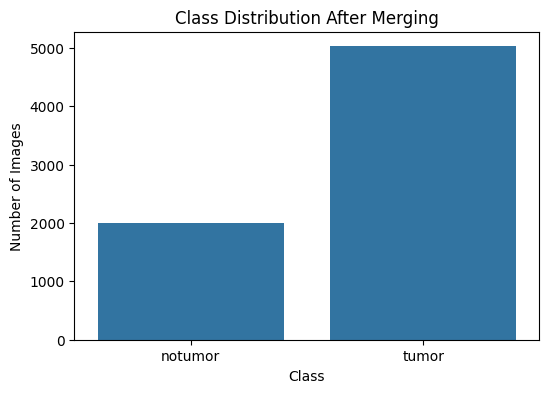

In [5]:
import pandas as pd
import os

merged_dir = "./merged_data"
data = []

for label in os.listdir(merged_dir):
    label_path = os.path.join(merged_dir, label)
    if os.path.isdir(label_path):
        for file in os.listdir(label_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                img_path = os.path.join(label_path, file)
                data.append({"image_path": img_path, "label": label})

df = pd.DataFrame(data)
print("Label counts:\n", df['label'].value_counts())

# Optional: visualize class distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title('Class Distribution After Merging')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

we have had a clear imbalance here between the two classes quantity

---

# Splitting the data and augementing

Importing necessary libraries

In [14]:
import os
import numpy as np
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)

Now to splitting data into  train, validation, and test sets.

We split the data before augementing it not to mix original and edited data.

In [16]:
def create_splits(base_dir, output_dir, test_size=0.15, val_size=0.15):
    """Split data into train/val/test directories, but do NOT create new folders."""
    for class_name in ['tumor', 'notumor']:
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            raise FileNotFoundError(f"Expected folder not found: {class_path}")
        images = [f for f in os.listdir(class_path) if f.endswith(('.png','.jpg','.jpeg'))]
        
        # Initial split: train+val vs test
        train_val, test = train_test_split(images, test_size=test_size, random_state=SEED)
        
        # Split train_val into train and val
        val_ratio = val_size / (1 - test_size)
        train, val = train_test_split(train_val, test_size=val_ratio, random_state=SEED)
        
        # Save to respective directories (must already exist)
        for split_name, split_data in [('train', train), ('val', val), ('test', test)]:
            dest_dir = os.path.join(output_dir, split_name, class_name)
            if not os.path.isdir(dest_dir):
                raise FileNotFoundError(f"Destination folder does not exist: {dest_dir}")
            for img_file in split_data:
                src = os.path.join(class_path, img_file)
                dst = os.path.join(dest_dir, img_file)
                shutil.copy(src, dst)

In [27]:
create_splits(
    base_dir="./merged_data",
    output_dir="inputs/brain_tumor_dataset/images",
    test_size=0.15,
    val_size=0.15
)

start augementation

Use the split training data as the source.
Augment the minority class in place.

In [29]:
def augment_training_set(train_dir):
    import os
    import numpy as np
    from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
    from tqdm import tqdm

    SEED = 42

    # Count images per class in the split training set
    class_counts = {}
    for label in os.listdir(train_dir):
        class_path = os.path.join(train_dir, label)
        if os.path.isdir(class_path):
            class_counts[label] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png','.jpg','.jpeg'))
            ])
    print("Class counts in training set:", class_counts)
    majority_class = max(class_counts, key=class_counts.get)
    minority_class = min(class_counts, key=class_counts.get)
    n_to_generate = class_counts[majority_class] - class_counts[minority_class]
    print(f"Majority: {majority_class}, Minority: {minority_class}, To generate: {n_to_generate}")

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    minority_path = os.path.join(train_dir, minority_class)
    image_files = [f for f in os.listdir(minority_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]

    for i in tqdm(range(n_to_generate), desc=f"Augmenting {minority_class}"):
        img_file = image_files[i % len(image_files)]
        img_path = os.path.join(minority_path, img_file)
        img = load_img(img_path)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        aug_iter = datagen.flow(x, batch_size=1, seed=SEED)
        aug_img = next(aug_iter)[0].astype(np.uint8)
        aug_img_pil = array_to_img(aug_img)
        aug_img_name = f"aug_{i}_{img_file}"
        aug_img_pil.save(os.path.join(minority_path, aug_img_name))
    print("Augmentation complete.")

# Call the function on your split training set
augment_training_set("inputs/brain_tumor_dataset/images/train")

Class counts in training set: {'notumor': 1396, 'tumor': 3515}
Majority: tumor, Minority: notumor, To generate: 2119


Augmenting notumor: 100%|██████████| 2119/2119 [00:58<00:00, 36.15it/s]

Augmentation complete.


Checking balance again 

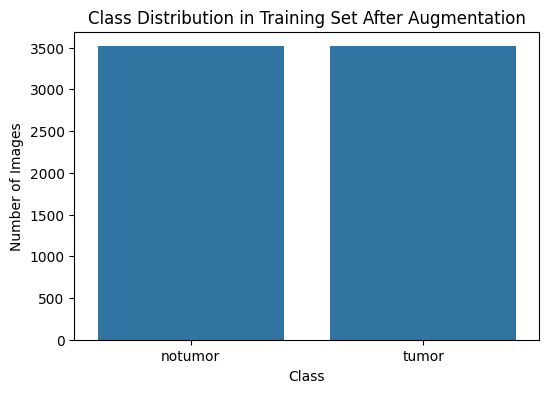

In [32]:
import pandas as pd

train_dir = "inputs/brain_tumor_dataset/images/train"
train_data = []

for label in os.listdir(train_dir):
    class_path = os.path.join(train_dir, label)
    if os.path.isdir(class_path):
        for file in os.listdir(class_path):
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                train_data.append({'image_path': os.path.join(class_path, file), 'label': label})

train_df = pd.DataFrame(train_data)

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train_df)
plt.title('Class Distribution in Training Set After Augmentation')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [25]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)


IndentationError: expected an indented block after 'try' statement on line 2 (1114530593.py, line 5)